In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-73d78d0a-ed4f-5a0d-2e4a-f6912777f8fc)


In [2]:
## Get data
# !git clone https://github.com/Frank-Dernoncourt/pubmed-rct
# !ls pubmed-rct

In [3]:
 import os

In [4]:
os.listdir(r'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/')

['dev.txt', 'test.txt', 'train.txt']

In [5]:
data_dir = r'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
filenames = [os.path.join(data_dir,i) for i in os.listdir(data_dir)]

In [7]:
filenames

['pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [8]:
def get_lines(filename):
    with open(filename,'r') as f:
        return f.readlines()

In [9]:
train_lines = get_lines(os.path.join(data_dir,"train.txt"))
train_lines[:100]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
            
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_lines.split("\t")
                line_data["target"] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split)-1
                abstract_samples.append(line_data)
        else:
            abstract_lines+= line
    return abstract_samples

In [11]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
%%time
train_samples =preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

Wall time: 606 ms


In [13]:
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [14]:
import pandas as pd

In [15]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(5)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

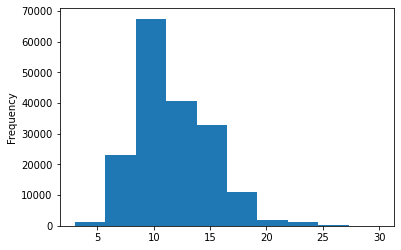

In [17]:
train_df.total_lines.plot(kind='hist')

### Get lists of sentences

In [18]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
# encode ke one hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)


In [21]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))

### Label enconde labels

In [22]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [23]:
from sklearn.preprocessing import LabelEncoder
# encode ke integer

In [24]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [25]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0 : baseline using naive bayes

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [27]:
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [29]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

In [30]:
import wget

In [31]:
#wget.download(r"https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

In [32]:
from helper_functions import calculate_results

In [33]:
baseline_results = calculate_results(test_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

### Preparing data text to deep sequence models

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [36]:
from tensorflow.keras import layers

In [37]:
sent_lens = [len(sentence.split()) for sentence in train_sentences ] 
avg_sent_len = np.mean(sent_lens)

In [38]:
np.mean(sent_lens)

26.338269273494777

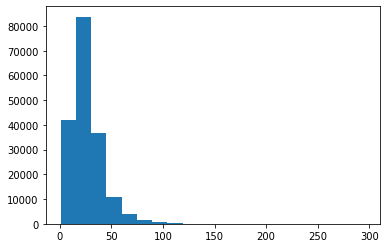

In [39]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [40]:
# long of sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [41]:
np.max(sent_lens)

296

### Convert words to number

In [42]:
max_tokens = 68000

In [43]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [44]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                   output_sequence_length=output_seq_len)

In [45]:
#Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [46]:
import random
target_sentenece = random.choice(train_sentences)
print(f"Text:\n{target_sentenece}")
print(f"Vectorized text:{text_vectorizer([target_sentenece])}")

Text:
blood potassium concentrations were assessed at baseline ( before study drug administration ) and at intervals up to @min after rocuronium , sugammadex , and succinylcholine .
Vectorized text:[[  107  2158   341     9   113    15    49   129    17   300   288     3
     15   890   303     6   242    21  4568  3866     3 16488     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [47]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"most common words in the vocab:{rct_20k_text_vocab[:5]}")

Number of words in vocab:64841
most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']


In [48]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

Create custom text embedding

In [49]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name='token_embbeding')


In [50]:
[target_sentenece]

['blood potassium concentrations were assessed at baseline ( before study drug administration ) and at intervals up to @min after rocuronium , sugammadex , and succinylcholine .']

In [51]:
import random
target_sentenece = random.choice(train_sentences)
print(f"Text:\n{target_sentenece}")
vectorized_sentence = text_vectorizer([target_sentenece])
print(f"Vectorized text:{vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embbed text:{embedded_sentence}")
print(f"Embbed text shape:{embedded_sentence.shape}")

Text:
clinicaltrials.gov , no .
Vectorized text:[[275  33   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
Embbed text:[[[-0.00785754 -0.02469641  0.02963987 ... -0.03096171 -0.00606657
    0.01517267]
  [-0.00097514  0.01702498 -0.00556169 ... -0.0397262   0.02930761
    0.03943678]
  [ 0.00111127 -0.00745739  0.02927789 ...  0.04357909 -0.01121835
   -0.00161965]
  ...
  [ 0.00111127 -0.00745739  0.02927789 ...  0.04357909 -0.01121835
   -0.00161965]
  [ 0.00111127 -0.00745739  0.02927789 ...  0.04357909 -0.01121835
   -0.00161965]
  [ 0.00111127 -0.00745739  0.02927789 ...  0.04357909 -0.01121835
   -0.00161965]]]
Embbed text shape:(1, 55, 128)


### Creating dataset with tf.data.API

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [53]:
train_dataset= train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset= valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [54]:
len(valid_dataset)

945

In [55]:
max_tokens

68000

In [56]:
num_classes

5

In [57]:

# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embbeding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [59]:
history_model_1 = model_1.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=5,
                              steps_per_epoch=int(1*len(train_dataset)),
                              validation_steps=int(0.1* len(valid_dataset))
                             )

Epoch 1/5
5627/5627 [==============================] - 51s 7ms/step - loss: 0.6119 - accuracy: 0.7776 - val_loss: 0.5432 - val_accuracy: 0.8012
Epoch 2/5
5627/5627 [==============================] - 42s 8ms/step - loss: 0.4498 - accuracy: 0.8424 - val_loss: 0.5388 - val_accuracy: 0.8062
Epoch 3/5
5627/5627 [==============================] - 42s 7ms/step - loss: 0.3691 - accuracy: 0.8743 - val_loss: 0.5725 - val_accuracy: 0.8005
Epoch 4/5
5627/5627 [==============================] - 43s 8ms/step - loss: 0.3045 - accuracy: 0.8990 - val_loss: 0.6349 - val_accuracy: 0.7899
Epoch 5/5
5627/5627 [==============================] - 43s 8ms/step - loss: 0.2503 - accuracy: 0.9190 - val_loss: 0.7142 - val_accuracy: 0.7862


In [60]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7061 - accuracy: 0.7939


[0.7060862183570862, 0.7939229607582092]

In [61]:
model_1_pred_probs = model_1.predict(valid_dataset)


In [62]:
model_1_preds = model_1_pred_probs.argmax(axis=1)

In [63]:
model_1_preds[:100]

array([0, 3, 3, 2, 2, 2, 4, 4, 4, 1, 1, 4, 1, 3, 2, 2, 4, 1, 1, 4, 0, 1,
       0, 1, 3, 0, 2, 2, 4, 2, 4, 3, 0, 1, 0, 2, 2, 2, 4, 4, 1, 1, 0, 1,
       3, 2, 2, 2, 4, 2, 2, 4, 4, 4, 4, 1, 4, 1, 0, 0, 0, 2, 2, 2, 2, 4,
       4, 3, 2, 2, 2, 4, 4, 4, 2, 4, 4, 4, 0, 3, 2, 2, 2, 2, 4, 4, 4, 4,
       1, 4, 1, 1, 3, 2, 2, 2, 2, 1, 2, 4], dtype=int64)

In [64]:
model_1_results = calculate_results(val_labels_encoded,model_1_preds)

In [65]:
model_1_results

{'accuracy': 79.39229445253542,
 'precision': 0.7913128217961111,
 'recall': 0.7939229445253542,
 'f1': 0.7914068217941956}

### Model 2: Feature extraction with pretrained token embeddings

In [66]:
# Download pretrained Tensorflow HUB USE

import tensorflow_hub as hub



In [67]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [68]:
target_sentenece = random.choice(train_sentences)
print(f"Text:\n{target_sentenece}")
vectorized_sentence = tf_hub_embedding_layer([target_sentenece])
print(f"Vectorized text:{vectorized_sentence.shape}")
# embedded_sentence = token_embed(vectorized_sentence)
# print(f"Embbed text:{embedded_sentence}")
# print(f"Embbed text shape:{embedded_sentence.shape}")

Text:
the control group were significantly less likely to quit smoking ( or = @ ; @ % ci = @-@ @ , p < @ ) .
Vectorized text:(1, 512)


In [69]:
inputs = layers.Input(shape=[],dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)

model_2 =tf.keras.Model(inputs,outputs,name='model_2')

# Compile
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,872,069
Trainable params: 74,245
Non-trainable params: 256,797,824
________________________________________

In [71]:
history_model_2=model_2.fit(train_dataset,
           validation_data=valid_dataset,
            steps_per_epoch=int(0.1*(len(train_dataset))),
           validation_steps=int(0.1*(len(valid_dataset))),
           epochs=5)

Epoch 1/5
562/562 [==============================] - 12s 18ms/step - loss: 0.8927 - accuracy: 0.6503 - val_loss: 0.7880 - val_accuracy: 0.6945
Epoch 2/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7480 - accuracy: 0.7085 - val_loss: 0.7251 - val_accuracy: 0.7131
Epoch 3/5
562/562 [==============================] - 9s 16ms/step - loss: 0.7183 - accuracy: 0.7235 - val_loss: 0.6899 - val_accuracy: 0.7334
Epoch 4/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6840 - accuracy: 0.7395 - val_loss: 0.6668 - val_accuracy: 0.7460
Epoch 5/5
562/562 [==============================] - 9s 16ms/step - loss: 0.6884 - accuracy: 0.7353 - val_loss: 0.6519 - val_accuracy: 0.7473


In [72]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.6611 - accuracy: 0.7473


[0.6610937118530273, 0.7472527623176575]

In [73]:
model_2_pred_prob  = model_2.predict(valid_dataset)

In [74]:
model_2_preds = model_2_pred_prob.argmax(axis=1)

In [75]:
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 74.72527472527473,
 'precision': 0.7433157105868108,
 'recall': 0.7472527472527473,
 'f1': 0.7416002430826598}

## Model 3: Conv1D with character embeddings

### Creating a character level tokenizer

In [76]:
def split_chars(text):
    return " ".join(list(text))



In [77]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [78]:
train_chars[0].split()

['t',
 'o',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 't',
 'h',
 'e',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 'o',
 'f',
 '@',
 'w',
 'e',
 'e',
 'k',
 's',
 'o',
 'f',
 'd',
 'a',
 'i',
 'l',
 'y',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 'o',
 'r',
 'a',
 'l',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 'i',
 'n',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 'p',
 'a',
 'i',
 'n',
 ',',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ',',
 'a',
 'n',
 'd',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 'i',
 'n',
 't',
 'h',
 'e',
 's',
 'h',
 'o',
 'r',
 't',
 't',
 'e',
 'r',
 'm',
 'a',
 'n',
 'd',
 'w',
 'h',
 'e',
 't',
 'h',
 'e',
 'r',
 't',
 'h',
 'e',
 'e',
 'f',
 'f',
 'e',
 'c',
 't',
 'w',
 'o',
 'u',
 'l',
 'd',
 'b',
 'e',
 's',
 'u',
 's',
 't',
 'a',
 'i',
 'n'

In [79]:
len(train_chars[0].split())

233

In [80]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

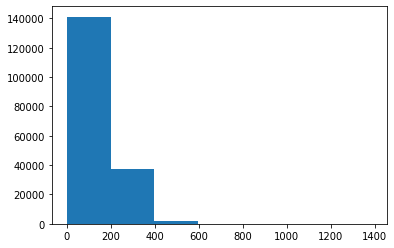

In [81]:
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [82]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [83]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [84]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   name='char_vectorizer')

In [85]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [86]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [87]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   d e v e l o p m e n t   r a t e s   o f   t o t a l   f l u i d   c o l l e c t i o n   ,   w o u n d   i n f e c t i o n   ,   f l a p   e d e m a   ,   h e m a t o m a   ,   a n d   p a r t i a l   w o u n d   s e p a r a t i o n   w e r e   @   %   ,   @   %   ,   @   %   ,   @   %   a n d   @   %   ,   r e s p e c t i v e l y   ;   t o t a l   f l a p   n e c r o s i s   w a s   n o t   o b s e r v e d   i n   a n y   p a t i e n t   (   p   <   @   )   .

Length of chars: 184

Vectorized chars:
[[ 3 13  2 10  2 21  2 12  7 14 15  2  6  3  8  5  3  2  9  7 17  3  7  3
   5 12 17 12 16  4 10 11  7 12 12  2 11  3  4  7  6 20  7 16  6 10  4  6
  17  2 11  3  4  7  6 17 12  5 14  2 10  2 15  5 13  2 15  5  3  7 15  5
   5  6 10 14  5  8  3  4  5 12 20  7 16  6 10  9  2 14  5  8  5  3  4  7
   6 20  2  8  2  5  6 10  8  2  9 14  2 11  3  4 21  2 12 19  3  7  3  5
  12 17 12  5 14  6  2 11  8  7  9  4  9 20  5  9  6  7  3  7 22  9  2  8
  21  2 10  4  6  5  6 19 1

### creating a character-level embedding

In [88]:
NUM_CHAR_TOKENS

70

In [92]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [93]:
Embedding_char = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=25,
                                  mask_zero=True,
                                  name='char_embed'
                                 )

In [94]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")
print(f"embed:{Embedding_char(vectorized_chars).shape}")

Charified text:
a t e n o l o l   a p p e a r s   t o   b e   a s   e f f e c t i v e   a s   p r o p r a n o l o l   .

Length of chars: 44

Vectorized chars:
[[ 5  3  2  6  7 12  7 12  5 14 14  2  5  8  9  3  7 22  2  5  9  2 17 17
   2 11  3  4 21  2  5  9 14  8  7 14  8  5  6  7 12  7 12  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

### building Conv1D model to fit on char embeddings

In [95]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = char_vectorizer(inputs)
x = Embedding_char(x)
x = layers.Conv1D(64,activation='relu',padding='same',kernel_size=5)(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs,name='model_3_conv1D_char_embedding')

In [96]:
model_3.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [97]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5

In [98]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [99]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [102]:

# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=5,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 7ms/step - loss: 1.2641 - accuracy: 0.4966 - val_loss: 1.0520 - val_accuracy: 0.5898
Epoch 2/5
562/562 [==============================] - 4s 7ms/step - loss: 1.0158 - accuracy: 0.5958 - val_loss: 0.9649 - val_accuracy: 0.6170
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.9383 - accuracy: 0.6333 - val_loss: 0.8927 - val_accuracy: 0.6443
Epoch 4/5
562/562 [==============================] - 8s 15ms/step - loss: 0.8858 - accuracy: 0.6585 - val_loss: 0.8583 - val_accuracy: 0.6686
Epoch 5/5
562/562 [==============================] - 9s 15ms/step - loss: 0.8712 - accuracy: 0.6628 - val_loss: 0.8369 - val_accuracy: 0.6679


In [103]:
model_3_pred_prob = model_3.predict(val_char_dataset)
model_3_pred_prob

array([[0.29434314, 0.30529192, 0.07319368, 0.3022063 , 0.02496494],
       [0.11723755, 0.6786062 , 0.01962652, 0.13160263, 0.05292705],
       [0.13562231, 0.2872997 , 0.21631922, 0.29234278, 0.06841598],
       ...,
       [0.02190248, 0.01955258, 0.12472519, 0.01921063, 0.81460905],
       [0.045737  , 0.09267555, 0.7205558 , 0.02680953, 0.1142221 ],
       [0.39181787, 0.50258523, 0.06606326, 0.03396078, 0.00557284]],
      dtype=float32)

In [104]:
model_3_preds = tf.argmax(model_3_pred_prob,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1], dtype=int64)>

In [105]:
model_3_results=calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 67.7247451343837,
 'precision': 0.680375004581816,
 'recall': 0.6772474513438369,
 'f1': 0.6719337333537361}

## Model 4: combining model 2 and model 3

In [107]:
token_inputs = layers.Input(shape=([]),dtype=tf.string,name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = Embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])


# create output layer

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation='softmax')(final_dropout)

model_4 = tf.keras.Model([token_model.input,char_model.input],output_layer,
                        name="model_4_token_and_char_embeddings")

In [135]:

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = Embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [136]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

In [124]:
from tensorflow.keras.utils import plot_model

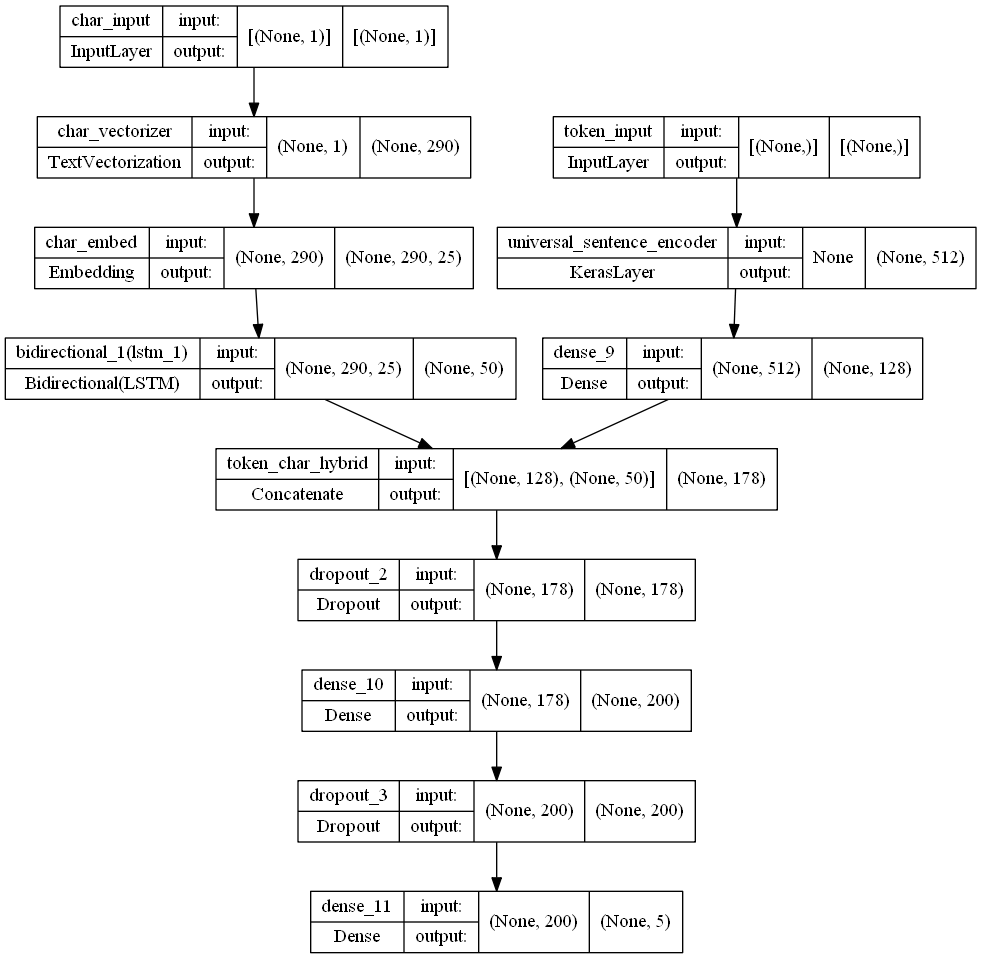

In [125]:
plot_model(model_4,show_shapes=True)

In [137]:
model_4.compile(loss='categorical_crossentropy',optimizer='adam',
               metrics=['accuracy'])

### Combining token and character data

In [117]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_lables = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_lables))

train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [118]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [119]:
train_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [128]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [202]:
7000/128

54.6875

In [204]:
len(train_char_token_dataset)

5627

In [203]:
int(0.1 * len(train_char_token_dataset))

562

In [205]:
5710//32

178

In [138]:

# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 46s 72ms/step - loss: 0.9511 - accuracy: 0.6192 - val_loss: 0.7642 - val_accuracy: 0.7081
Epoch 2/5
562/562 [==============================] - 38s 67ms/step - loss: 0.7829 - accuracy: 0.6959 - val_loss: 0.7000 - val_accuracy: 0.7344
Epoch 3/5
562/562 [==============================] - 36s 63ms/step - loss: 0.7620 - accuracy: 0.7065 - val_loss: 0.6802 - val_accuracy: 0.7414
Epoch 4/5
562/562 [==============================] - 40s 71ms/step - loss: 0.7288 - accuracy: 0.7241 - val_loss: 0.6596 - val_accuracy: 0.7503
Epoch 5/5
562/562 [==============================] - 37s 66ms/step - loss: 0.7313 - accuracy: 0.7206 - val_loss: 0.6488 - val_accuracy: 0.7507


In [139]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 29s 30ms/step - loss: 0.6551 - accuracy: 0.7486


[0.6551218032836914, 0.7485767006874084]

In [140]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)

In [141]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)

In [142]:
model_4_results = calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 74.8576724480339,
 'precision': 0.743984314598593,
 'recall': 0.748576724480339,
 'f1': 0.7430911549217798}

## Model 5: Transfer learing token embed +char embed + pos embed

In [144]:
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Create positional embeddings

In [149]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

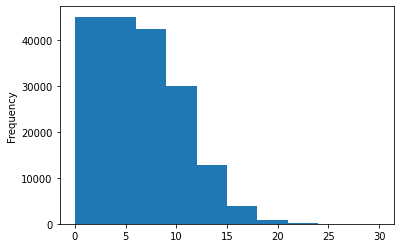

In [150]:
train_df["line_number"].plot(kind='hist')

In [147]:
np.percentile(train_df["line_number"].values,98)

15.0

In [152]:
tf.one_hot(train_df["line_number"].to_numpy(),depth=15)

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [155]:
# use tensorflow to create one-hot-encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

### do the same to total_lines

In [156]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [164]:
np.percentile(train_df.total_lines.values,98)

20.0

<AxesSubplot:ylabel='Frequency'>

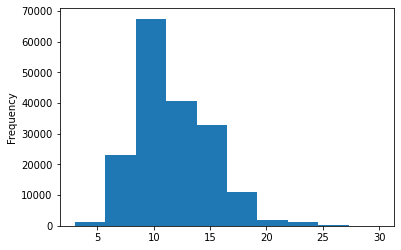

In [160]:
train_df.total_lines.plot.hist()

In [173]:
train_df[train_df.total_lines==28]

,target,text,line_number,total_lines
10464,OBJECTIVE,applied kinesiology ( ak ) is a diagnostic tec...,0,28
10465,OBJECTIVE,"in essence , it posits that a question can be ...",1,28
10466,OBJECTIVE,this ak is presumed to have a diagnostic capab...,2,28
10467,OBJECTIVE,"that being presumed , this study asks the foll...",3,28
10468,OBJECTIVE,( @ ) is this effect a transaction involving i...,4,28
10469,OBJECTIVE,"( @ ) as an extension of question @ , is the r...",5,28
10470,OBJECTIVE,"( @ ) does belief , expectation , gender , or ...",6,28
10471,METHODS,"to answer these questions , which would help t...",7,28
10472,METHODS,grip strength being a self-administered ak tes...,8,28
10473,METHODS,"for each trial , a pair of randomly numbered s...",9,28


In [169]:
train_df.iloc[135320]

target                                               CONCLUSIONS
text           no such correlation between the fracture type ...
line_number                                                   30
total_lines                                                   30
Name: 135320, dtype: object

In [174]:
train_total_lines_one_hot[10492	]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [171]:
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(),depth=20)

In [186]:

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = Embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
outputs = layers.Dense(32,activation='relu')(line_number_inputs )
line_model = tf.keras.Model(inputs=line_number_inputs,
                            outputs=outputs)

total_line_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="total_line_input")
outputs = layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                            outputs=outputs)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output,
                                                                 line_model.output,
                                                                 total_line_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input,
                             line_model.input,
                             total_line_model.input],
                         outputs=output_layer,
                         name="model_5_token_and_char_embeddings_pos_embeddings")

In [222]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = Embedding_char(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_input")
outputs = layers.Dense(32,activation='relu')(line_number_inputs )
line_model = tf.keras.Model(inputs=line_number_inputs,
                            outputs=outputs)

total_line_inputs = layers.Input(shape=(20,),dtype=tf.float32, name="total_line_input")
outputs = layers.Dense(32,activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                            outputs=outputs)



combined_embeddings= layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output,])

z = layers.Dense(256,activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribid_embeddings = layers.Concatenate(name="pos_token_char_hybrid")([line_model.output, 
                                                                  total_line_model.output,
                                                                 z])

output_layer = layers.Dense(num_classes, activation="softmax")(tribid_embeddings)

model_5 = tf.keras.Model(inputs=[line_model.input,
                                total_line_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer,
                        name="tribrid_embedding_model")

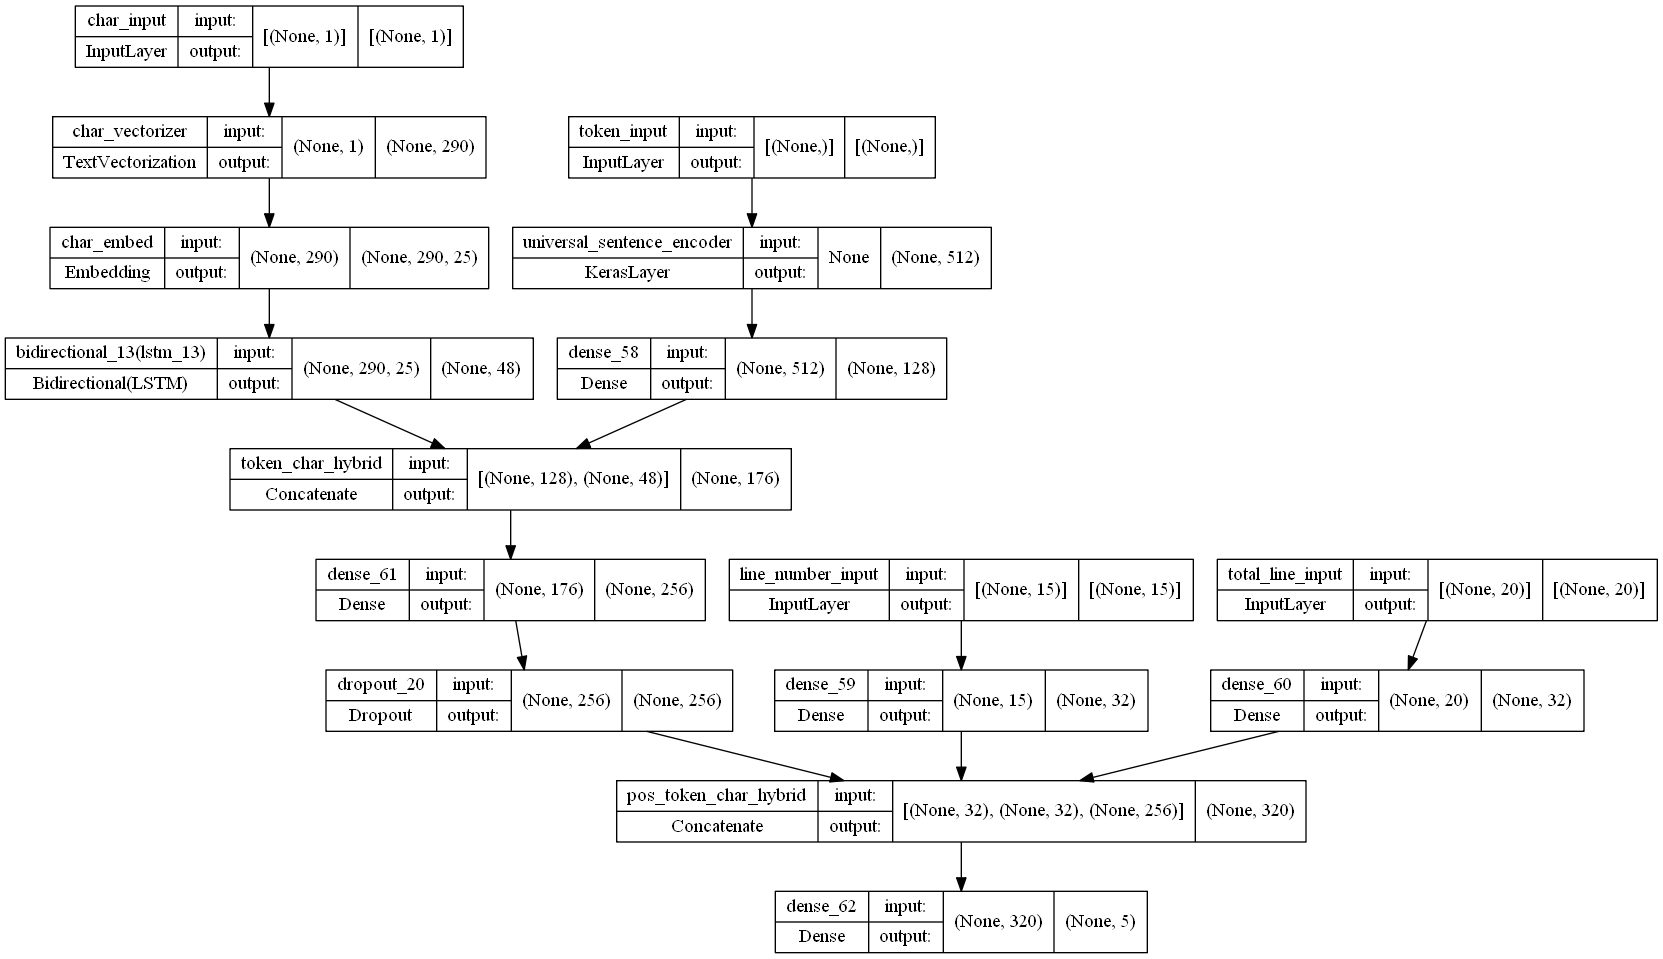

In [223]:
plot_model(model_5,show_shapes=True)

In [224]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer='adam',
               metrics=['accuracy'])

In [225]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)                                                   

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
                                                   
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  

In [226]:
train_char_token_pos_dataset,val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [227]:
# Fit the model on tokens and chars
model_5_history = model_5.fit(train_char_token_pos_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 58s 86ms/step - loss: 1.0976 - accuracy: 0.7190 - val_loss: 0.9845 - val_accuracy: 0.8009
Epoch 2/5
562/562 [==============================] - 37s 67ms/step - loss: 0.9676 - accuracy: 0.8144 - val_loss: 0.9505 - val_accuracy: 0.8231
Epoch 3/5
562/562 [==============================] - 33s 59ms/step - loss: 0.9500 - accuracy: 0.8226 - val_loss: 0.9398 - val_accuracy: 0.8344
Epoch 4/5
562/562 [==============================] - 38s 68ms/step - loss: 0.9389 - accuracy: 0.8372 - val_loss: 0.9299 - val_accuracy: 0.8368
Epoch 5/5
562/562 [==============================] - 35s 62ms/step - loss: 0.9362 - accuracy: 0.8366 - val_loss: 0.9244 - val_accuracy: 0.8421


In [232]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)

In [234]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1], dtype=int64)>

In [237]:
model_5_results = calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 84.27115053621078,
 'precision': 0.8451501555224132,
 'recall': 0.8427115053621078,
 'f1': 0.8390221963838699}

In [238]:
model_4_results

{'accuracy': 74.8576724480339,
 'precision': 0.743984314598593,
 'recall': 0.748576724480339,
 'f1': 0.7430911549217798}

## Compare all model results

In [252]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,71.667496,0.712432,0.716675,0.692510
custom_token_embed_conv1d,79.392294,0.791313,0.793923,0.791407
pretrained_token_embed,74.725275,0.743316,0.747253,0.741600
custom_char_embed_conv1d,67.724745,0.680375,0.677247,0.671934
hybrid_char_token_embed,74.857672,0.743984,0.748577,0.743091
tribrid_pos_char_token_embed,84.271151,0.845150,0.842712,0.839022


In [255]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

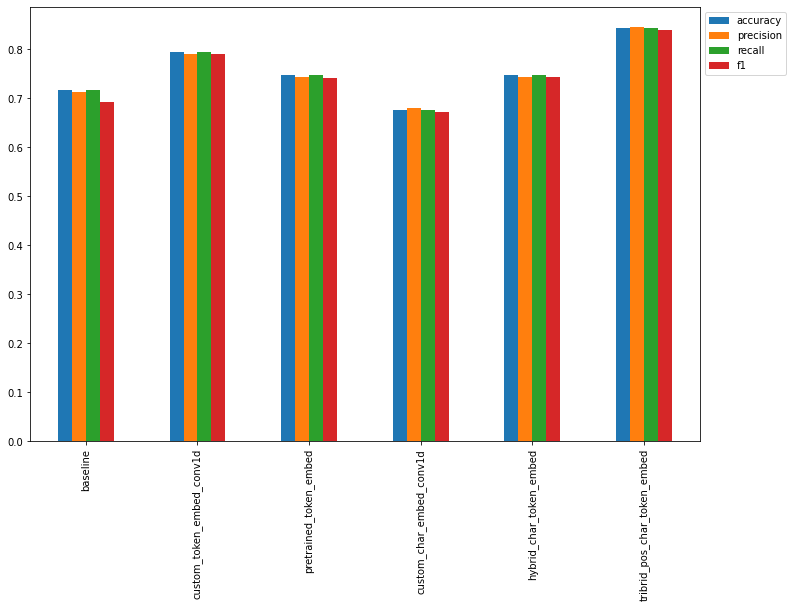

In [259]:
all_model_results.plot(figsize=(12,8),kind='bar').legend(bbox_to_anchor=(1.0,1.0));

<AxesSubplot:>

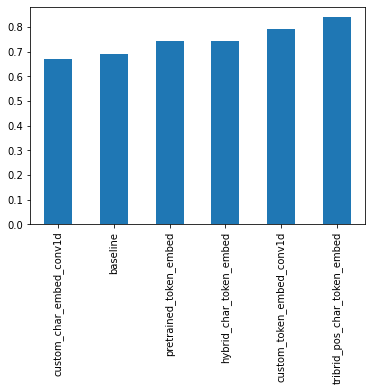

In [262]:
all_model_results.sort_values("f1")["f1"].plot(kind='bar')

In [263]:
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


In [264]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model/")

In [265]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [266]:
loaded_model_results = calculate_results(val_labels_encoded,loaded_preds)

In [268]:
loaded_model_results

{'accuracy': 84.27115053621078,
 'precision': 0.8451501555224132,
 'recall': 0.8427115053621078,
 'f1': 0.8390221963838699}

In [267]:
model_5_results

{'accuracy': 84.27115053621078,
 'precision': 0.8451501555224132,
 'recall': 0.8427115053621078,
 'f1': 0.8390221963838699}

In [269]:
loaded_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

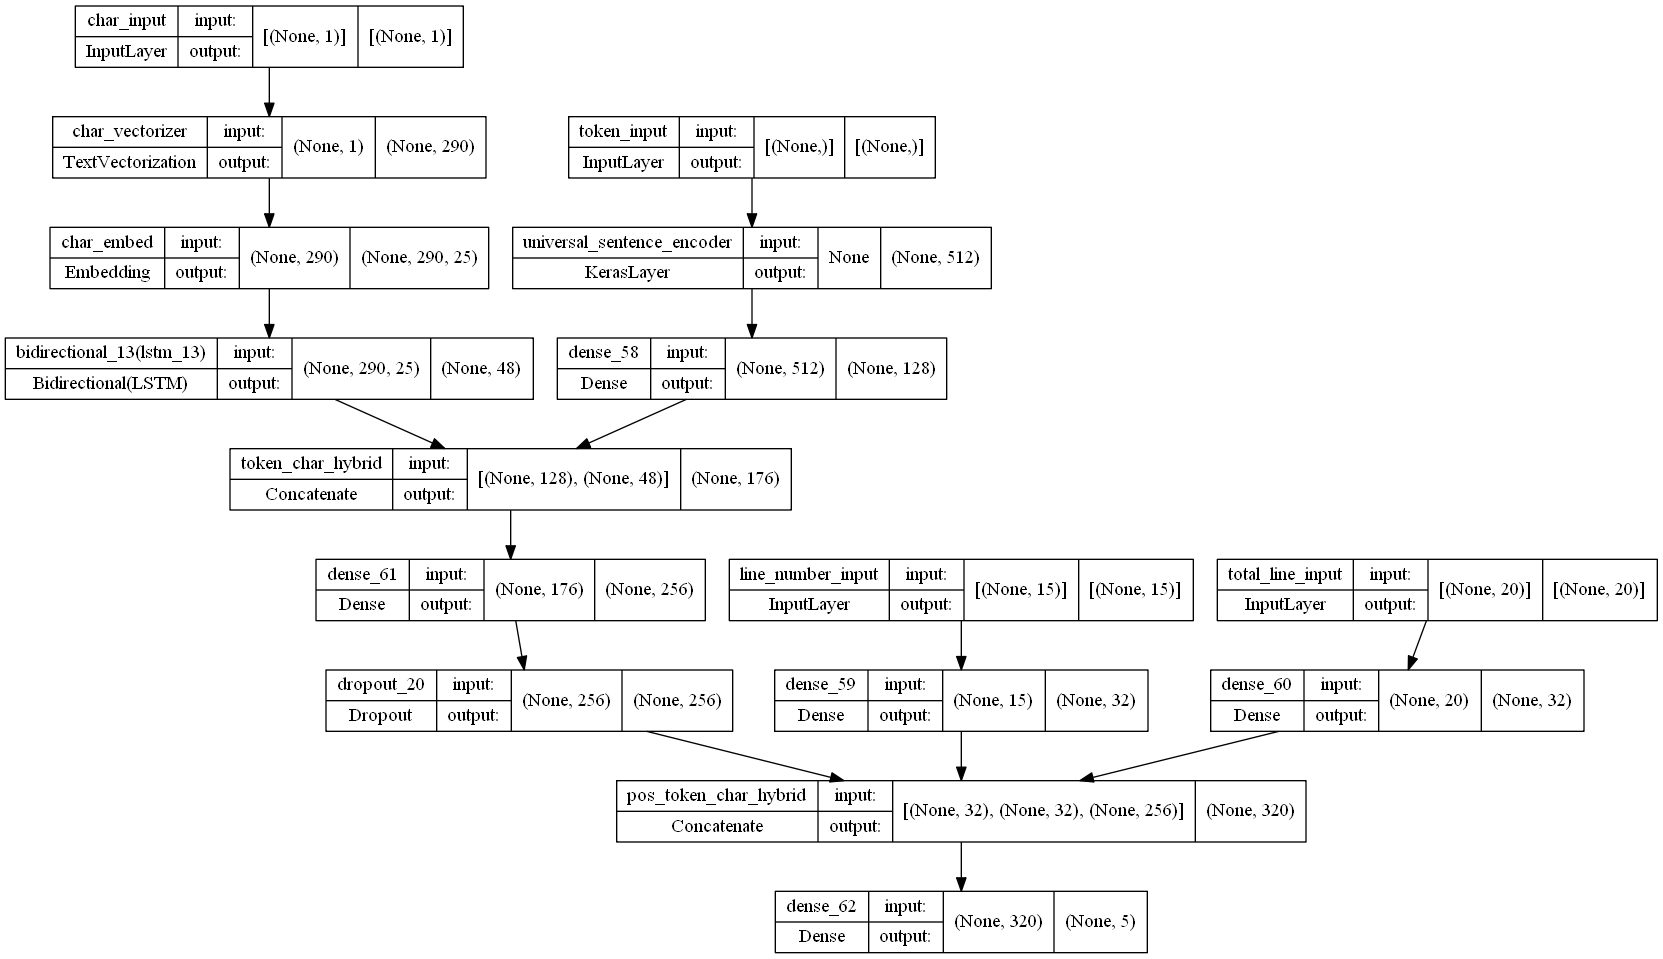

In [271]:
plot_model(loaded_model,show_shapes=True)

In [230]:
len(train_sentences)//32

5626

In [231]:
len(train_char_dataset)*0.1

562.7

In [ ]:
train_labels_one_hot

In [ ]:
train

In [ ]:
## Adapt character vectorizer to training character

char_vectorizer.adapt(train_chars)



In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

In [ ]:
char_vocab[:5]

In [ ]:
target_sentenece = random.choice(train_chars)
print(f"Text:\n{target_sentenece}")
vectorized_sentence = char_vectorizer([target_sentenece])
print(f"Vectorized text:{vectorized_sentence}")
# embedded_sentence = token_embed(vectorized_sentence)
# print(f"Embbed text:{embedded_sentence}")
# print(f"Embbed text shape:{embedded_sentence.shape}")

In [ ]:
train_sentences[:5]

In [ ]:
" ".join(list(train_sentences[0]))[:10]

In [ ]:
[train_se]

In [ ]:
token

In [ ]:
import regex as re

In [ ]:
 obj=[]
    methods=[]
    background=[]
    conc=[]
    results=[]

In [ ]:

def prep(filename):
    prep_dict = {}
    
   # texts = get_lines(filename)
    for text in filename:
        regex_search=re.search("([A-Z]*)\t(.*)",text)
        if regex_search is None:
            continue
        elif type(regex_search)!= None and regex_search.group(1) not in prep_dict.keys():
            prep_dict[regex_search.group(1)] = []
            prep_dict[regex_search.group(1)].append(regex_search.group(2))
        else:
            prep_dict[regex_search.group(1)].append(regex_search.group(2))
    return prep_dict
            

In [ ]:
filenames[0]

In [ ]:
p=prep(train_lines)

In [ ]:
len(p["OBJECTIVE"])

In [ ]:
test=re.search("([A-Z]*)\t(.*)",train_lines[0])

In [ ]:
len(test)

In [ ]:
with open(filenames[0],'r') as f:
    print(f.readlines())

In [ ]:
os.listdir(r"E:\jupyter\udemy\ztm_Tensor\Skimlit\pubmed-rct-master\PubMed_20k_RCT_numbers_replaced_with_at_sign")